# Name Categorizer Exercise

The following notebook is an exercise from the Pytorch documentation on classifying names. A similiar approach could be taken to predict ambiguous gender pronouns.

The purpose of this exercise is to understand if there are any relevant techniques that could be transfered to the Gender Pronoun problem.

The following walkthrough and proper explanation can be found [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

## 2) Standard Imports & Data Loader

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + "..;'"
n_letters = len(all_letters)

# Turn unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


Now we have ```category_lines```, a dictionary mapping each category (the language) to a list of lines(names). We also kept track of all_categories

In [2]:
# Example of the first 5 names for Italian names
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## 2) Features Engineering 

### Turning Names into Tensors

We will use __one-hot vectors__ to represent a single letter. One-hot vectors are filled with 0s except for a 1 at the index of the current letter.

In short, we get a vector with the length of the alphabet, where the 1 will be located in the index position of its respective letter. 

For example the letter _"B"_ will be at index 1 (second position), and the vector would look some thing like:

```python
"b" = <0, 1, 0, 0, 0,... 0>
```

To make a word we join many of these vectors into a __matrix__

In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Demonstration for turning letter into a <1 x n_letters> tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x N_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jonas').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


## 3) Creating our RNN

We will be building a neural net with Pytorch, specifically a __recurrent neural network__. 

This RNN is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output

In [10]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [11]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency, we don't want to be creating a new tensor for every step, so we'll use ```lineToTensor``` instead of ```letterToTensor``` and use slices. This could be further optimized by pre-computing batches of Tensors.

In [13]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0086, -2.9481, -2.9822, -2.9283, -2.7967, -2.8753, -2.8884, -2.8074,
         -3.0156, -2.8377, -2.9576, -2.8805, -2.7816, -2.8045, -2.8114, -2.8715,
         -2.9820, -2.8993]], grad_fn=<LogSoftmaxBackward>)


## 4) Prep for Training

Before going into training, we'll make some helper functions.

The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use ```Tensor.topk``` to get the index of the greatest value:

In [14]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 12)


We'll also want a quick way to get a training example (a name and its language)

In [17]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('Category: ', category, '|| line:', line)

Category:  Spanish || line: Santos
Category:  Korean || line: Kwang
Category:  Portuguese || line: Souza
Category:  Arabic || line: Sabbagh
Category:  Japanese || line: Kikuchi
Category:  Arabic || line: Boulos
Category:  Czech || line: Prill
Category:  Dutch || line: Simon
Category:  Italian || line: Buffone
Category:  Korean || line: Hong


## 5) Training

For the loss function , we will use ```nn.NLLLoss()```, since the last layer of the RNN is ```nn.LogSoftmax```.

In [18]:
criterion = nn.NLLLoss()

Each iteration of training will:

- Create input and target tensors
- Create a zeroed initial state
- Read each letter in and keep kiddne state for next letter
- Compare final output to target
- Back-prop
- Return output & loss

In [29]:
# Setting learning rate hyperparam
learning_rate = 0.0005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add params gradient to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add(-learning_rate, p.grad.data)
    
    return output, loss.item()

Now to run our tests on our training data

In [31]:
import time
import math

n_iters = 1000000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        if guess == category:
            correct = '!' 
        else:
            correct = 'x (%s)' % category
            
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 0% (0m 4s) 2.9378 Arato / Italian x (Japanese)
10000 1% (0m 9s) 2.9404 Olguin / Italian x (Spanish)
15000 1% (0m 13s) 2.7446 Xian / Italian x (Chinese)
20000 2% (0m 18s) 2.9403 Murata / Italian x (Japanese)
25000 2% (0m 23s) 2.7751 Yin / Italian x (Chinese)
30000 3% (0m 28s) 2.8021 Janda / Italian x (Polish)
35000 3% (0m 32s) 2.8327 Schneider / Vietnamese x (Dutch)
40000 4% (0m 37s) 2.9648 Bertsimas / Chinese x (Greek)
45000 4% (0m 42s) 2.9746 Sauber / French x (German)
50000 5% (0m 47s) 2.9057 Loifman / Italian x (Russian)
55000 5% (0m 52s) 2.8583 Lachapelle / Italian x (French)
60000 6% (0m 57s) 2.8097 Piontek / Vietnamese x (Polish)
65000 6% (1m 2s) 2.9219 Kouches / Chinese x (Greek)
70000 7% (1m 8s) 2.9888 Quinn / Italian x (Irish)
75000 7% (1m 13s) 2.9687 Kruger / Vietnamese x (German)
80000 8% (1m 19s) 2.7202 Cuan / Chinese !
85000 8% (1m 24s) 2.9211 Egonidis / Vietnamese x (Greek)
90000 9% (1m 29s) 2.8047 Nunes / Vietnamese x (Portuguese)
95000 9% (1m 34s) 2.7965 Sinclair /

KeyboardInterrupt: 

## 6) Plotting The Results

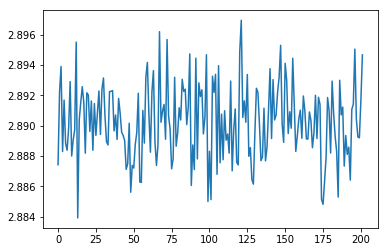

In [32]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses);